In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
i

In [3]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [3]:
# If your file is uploaded directly to Colab
!unzip /archive.zip -d /dataset

# OR if you want to check the contents first
!ls /dataset

unzip:  cannot find or open /archive.zip, /archive.zip.zip or /archive.zip.ZIP.
ls: /dataset: No such file or directory


In [4]:
!pip install -q grad-cam

In [6]:
# First install Kornia
!pip install kornia

# Then import it
import kornia
import kornia.augmentation as K

ImportError: cannot import name 'TypeIs' from 'typing_extensions' (/Users/sumanpatra/anaconda3/lib/python3.11/site-packages/typing_extensions.py)

In [10]:
from PIL import Image
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
from typing import Tuple
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
# import kornia.augmentation as K
import seaborn as sns
import torch.optim as optim
import torch.nn as nn
import torch
import pandas as pd
import numpy as np
import random
import warnings
import os

warnings.filterwarnings('ignore')
matplotlib.style.use('ggplot')

In [11]:
# For reproducibility
seed = 27
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [15]:
tumors_path = '/dataset/yes/'
no_tumors_path = '/dataset/no/'

In [16]:

# Plot tumor images
for i in range(5):
    image_file = random.choice(os.listdir(tumors_path))
    image = Image.open(tumors_path + image_file)
    ax[i].imshow(image, cmap='gray')
    ax[i].set_title(f'Tumor: {image_file}', color=colors[0], fontsize=10)
    ax[i].axis('off')  # Hide axes

# Plot no-tumor images
for i in range(5, 10):
    image_file = random.choice(os.listdir(no_tumors_path))
    image = Image.open(no_tumors_path + image_file)
    ax[i].imshow(image, cmap='gray')
    ax[i].set_title(f'No Tumor: {image_file}', color=colors[1], fontsize=10)
    ax[i].axis('off')  # Hide axes

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

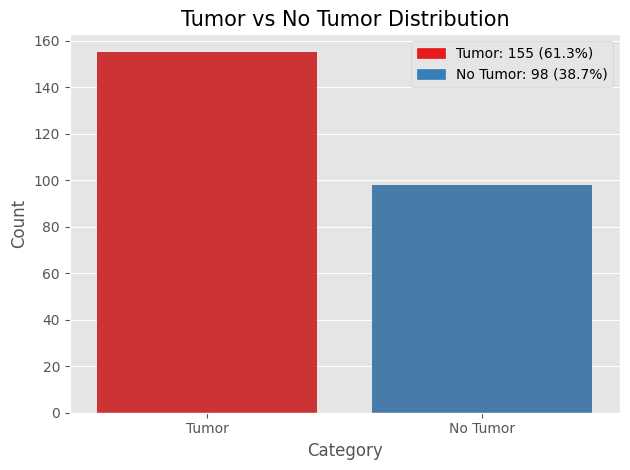

In [17]:
plt.rcParams['axes.grid'] = True

df = pd.DataFrame({
    'Category': ['Tumor', 'No Tumor'],
    'Count': [len(os.listdir(tumors_path)), len(os.listdir(no_tumors_path))]
})
total = df['Count'].sum()
df['Percentage'] = df['Count'] / total * 100

ax = sns.barplot(x='Category', y='Count', data=df, palette=colors)
legend_labels = [f'{row.Category}: {row.Count} ({row.Percentage:.1f}%)' for _, row in df.iterrows()]
patches = [mpatches.Patch(color=colors[i], label=label) for i, label in enumerate(legend_labels)]
ax.legend(handles=patches, title_fontsize='13', loc='best')
plt.title('Tumor vs No Tumor Distribution', fontsize=15)
plt.tight_layout()
plt.show()

In [18]:
augmented_tumors_path = '/dataset/yes/'
augmented_no_tumors_path = '/dataset/no/'

try:
    os.mkdir('/dataset/augmented_dataset/')
    os.mkdir('/dataset/augmented_dataset/yes/')
    os.mkdir('/dataset/augmented_dataset/no/')
except:
    pass

In [19]:
def generate_augmentations(path: str, augmented_path: str) -> None:
    augmentations = [
        K.RandomHorizontalFlip(p=1.0),
        K.RandomVerticalFlip(p=1.0),
        K.RandomRotation(degrees=15, p=1.0),
        K.RandomAffine(degrees=15, p=1.0),
        K.RandomElasticTransform(p=1.0),
        K.RandomGaussianBlur(kernel_size=(5, 9), p=1.0, sigma=(0.1, 5.0)),
        K.RandomSharpness(p=1.0),
    ]

    for image in os.listdir(path):
        # Reading the image into PIL format
        img = Image.open(path + image).convert('L')

        file_extension = image.split('.')[1]
        file_name = image.split('.')[0].replace(' ', '-')

        # Saving the original image
        img.save(f'{augmented_path}{file_name}_Original.{file_extension}')

        # Convertering th PIL image to tensor to apply augmentations to it
        img = transforms.ToTensor()(img)
        for aug in augmentations:
            augmented = aug(img)
            augmented = augmented.squeeze(0)
            augmented = augmented.squeeze(0)

            # Convertering the tensor image back to PIL image and saving
            augmented = transforms.ToPILImage()(augmented)
            augmented.save(f'{augmented_path}{file_name}_{aug.__class__.__name__}.{file_extension}')


generate_augmentations(tumors_path, augmented_tumors_path)
generate_augmentations(no_tumors_path, augmented_no_tumors_path)

print('Original dataset size: ', len(os.listdir(tumors_path)) + len(os.listdir(no_tumors_path)))
print('Augmented dataset size: ', len(os.listdir(augmented_tumors_path)) + len(os.listdir(augmented_no_tumors_path)))

Original dataset size:  2277
Augmented dataset size:  2277


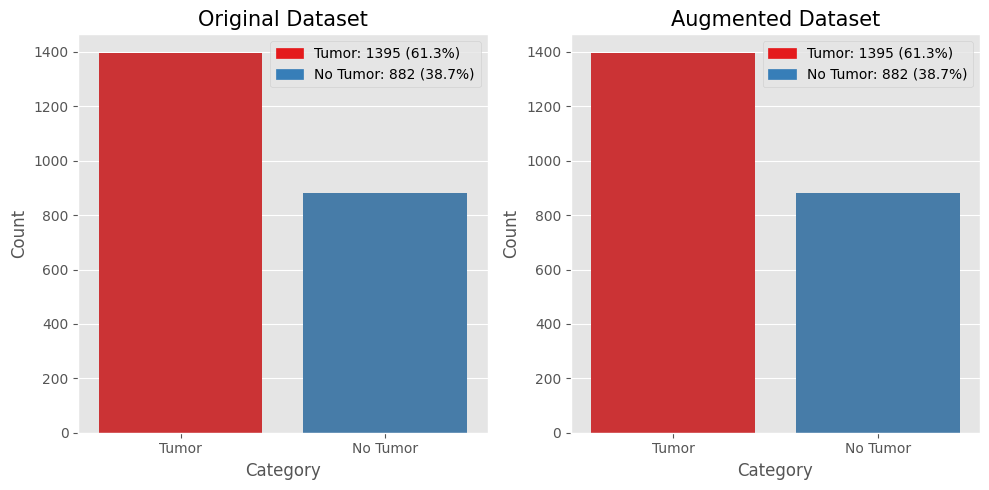

In [20]:
df = pd.DataFrame({
    'Category': ['Tumor', 'No Tumor'],
    'Count': [len(os.listdir(tumors_path)), len(os.listdir(no_tumors_path))]
})
total = df['Count'].sum()
df['Percentage'] = df['Count'] / total * 100

df_augmented = pd.DataFrame({
    'Category': ['Tumor', 'No Tumor'],
    'Count': [len(os.listdir(augmented_tumors_path)), len(os.listdir(augmented_no_tumors_path))]
})
total_augmented = df_augmented['Count'].sum()
df_augmented['Percentage'] = df_augmented['Count'] / total_augmented * 100

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.barplot(x='Category', y='Count', data=df, palette=colors, ax=ax[0])
sns.barplot(x='Category', y='Count', data=df_augmented, palette=colors, ax=ax[1])

legend_labels = [f'{row.Category}: {row.Count} ({row.Percentage:.1f}%)' for _, row in df.iterrows()]
patches = [mpatches.Patch(color=colors[i], label=label) for i, label in enumerate(legend_labels)]
ax[0].legend(handles=patches, title_fontsize='13', loc='best')
ax[0].set_title('Original Dataset', fontsize=15)

legend_labels = [f'{row.Category}: {row.Count} ({row.Percentage:.1f}%)' for _, row in df_augmented.iterrows()]
patches = [mpatches.Patch(color=colors[i], label=label) for i, label in enumerate(legend_labels)]
ax[1].legend(handles=patches, title_fontsize='13', loc='best')
ax[1].set_title('Augmented Dataset', fontsize=15)

plt.tight_layout()
plt.show()

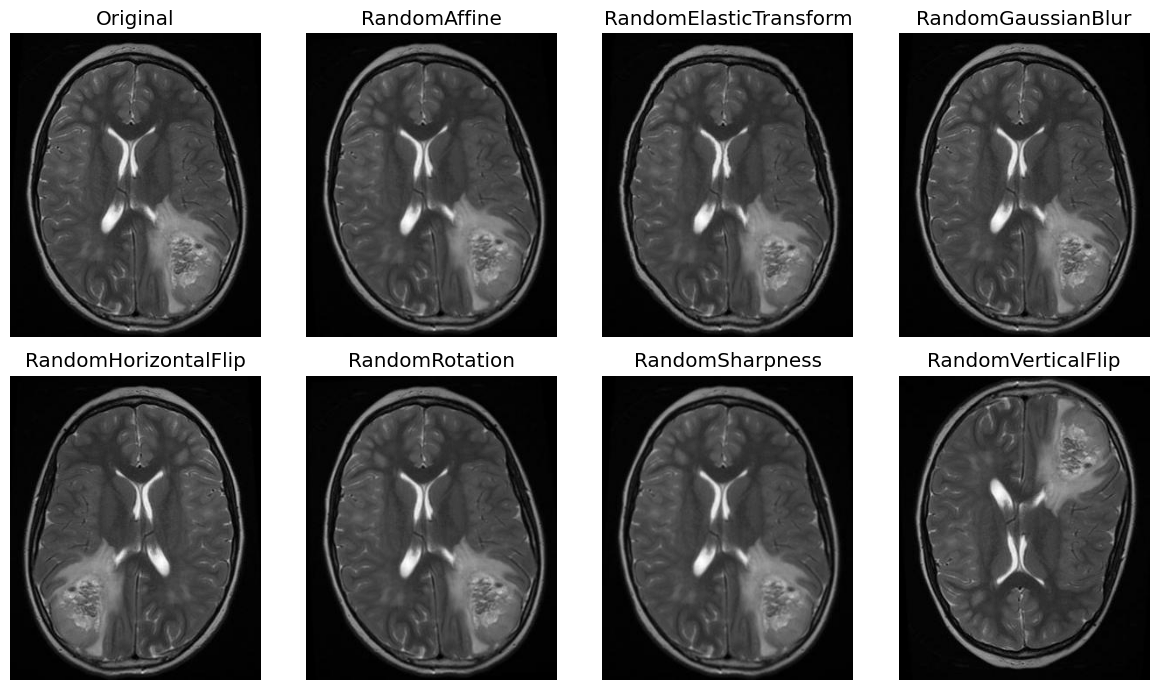

In [21]:
samples = [
    augmented_tumors_path + 'Y100_Original.JPG',
    augmented_tumors_path + 'Y100_RandomAffine.JPG',
    augmented_tumors_path + 'Y100_RandomElasticTransform.JPG',
    augmented_tumors_path + 'Y100_RandomGaussianBlur.JPG',
    augmented_tumors_path + 'Y100_RandomHorizontalFlip.JPG',
    augmented_tumors_path + 'Y100_RandomRotation.JPG',
    augmented_tumors_path + 'Y100_RandomSharpness.JPG',
    augmented_tumors_path + 'Y100_RandomVerticalFlip.JPG',
]

fig, axs = plt.subplots(2, 4, figsize=(12, 7))
start_index = 0
for row in range(2):
    for col in range(4):
        filename = Image.open(samples[start_index])
        aug_type = filename.filename.split('/')[-1].split('_')[-1].split('.')[0]
        axs[row, col].imshow(filename, cmap='gray')
        axs[row, col].set_title(aug_type)
        axs[row, col].axis('off')
        start_index += 1

plt.tight_layout()
plt.show()

In [32]:
# Import required libraries
import os
import numpy as np
from PIL import Image
from typing import Tuple

def create_directory(path: str) -> None:
    try:
        os.makedirs(path)
    except FileExistsError:
        pass

def split_data(data: list, train_ratio: float = 0.8, val_ratio: float = 0.1) -> Tuple[list, list, list]:
    np.random.shuffle(data)
    train_end = int(len(data) * train_ratio)
    val_end = int(len(data) * (train_ratio + val_ratio))
    return data[:train_end], data[train_end:val_end], data[val_end:]

def save_images(data: list, source_dir: str, target_dir: str) -> None:
    for filename in data:
        img = Image.open(os.path.join(source_dir, filename))
        img.save(os.path.join(target_dir, filename))

# Define directories for Google Colab
dataset_dirs = [
    '/content/dataset/train/yes',
    '/content/dataset/train/no',
    '/content/dataset/val/yes',
    '/content/dataset/val/no',
    '/content/dataset/test/yes',
    '/content/dataset/test/no'
]

# Create directories
for dir_path in dataset_dirs:
    create_directory(dir_path)

# Define paths for your augmented data
augmented_tumors_path = '/dataset/augmented_dataset/yes/'    # Adjust this path
augmented_no_tumors_path = '/dataset/augmented_dataset/no/'  # Adjust this path

# Get list of images
tumors = os.listdir(augmented_tumors_path)
no_tumors = os.listdir(augmented_no_tumors_path)

# Split the data
tumors_train, tumors_val, tumors_test = split_data(tumors)
no_tumors_train, no_tumors_val, no_tumors_test = split_data(no_tumors)

# Save the split datasets
save_images(tumors_train, augmented_tumors_path, '/content/dataset/train/yes')
save_images(tumors_val, augmented_tumors_path, '/content/dataset/val/yes')
save_images(tumors_test, augmented_tumors_path, '/content/dataset/test/yes')

save_images(no_tumors_train, augmented_no_tumors_path, '/content/dataset/train/no')
save_images(no_tumors_val, augmented_no_tumors_path, '/content/dataset/val/no')
save_images(no_tumors_test, augmented_no_tumors_path, '/content/dataset/test/no')

# Print dataset statistics
print("\nDataset Statistics:")
print(f"Tumor images - Train: {len(tumors_train)}, Val: {len(tumors_val)}, Test: {len(tumors_test)}")
print(f"No tumor images - Train: {len(no_tumors_train)}, Val: {len(no_tumors_val)}, Test: {len(no_tumors_test)}")


Dataset Statistics:
Tumor images - Train: 0, Val: 0, Test: 0
No tumor images - Train: 0, Val: 0, Test: 0


In [36]:
# Import required libraries
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import os

# Constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
NUM_WORKERS = 2  # Reduced for Colab to prevent memory issues
DATA_TYPES = ['train', 'val', 'test']

# Set data directory
data_dir = '/dataset'  # Updated for Google Colab path

# Define data transformations
data_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.2470, 0.2470, 0.2470], [0.2364, 0.2364, 0.2364])
])

# Create dataset dictionaries
image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x),
        data_transforms
    ) for x in DATA_TYPES
}

# Create dataloaders
dataloaders = {
    x: DataLoader(
        image_datasets[x],
        batch_size=BATCH_SIZE,
        shuffle=True if x == 'train' else False,  # Only shuffle training data
        num_workers=NUM_WORKERS,
        pin_memory=True  # Added for faster data transfer to GPU
    ) for x in DATA_TYPES
}

# Get dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in DATA_TYPES}

# Get class names
class_names = image_datasets['train'].classes

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Print dataset information
print("\nDataset Information:")
print(f"Device being used: {device}")
print(f"Number of classes: {len(class_names)}")
print(f"Class names: {class_names}")
print("\nDataset sizes:")
for data_type in DATA_TYPES:
    print(f"{data_type}: {dataset_sizes[data_type]} images")

# Verify data loading
try:
    for data_type in DATA_TYPES:
        images, labels = next(iter(dataloaders[data_type]))
        print(f"\n{data_type} batch shape: {images.shape}")
        print(f"{data_type} labels shape: {labels.shape}")
except Exception as e:
    print(f"Error in data loading: {e}")

FileNotFoundError: [Errno 2] No such file or directory: '/dataset/train'

In [ ]:
class Trainer:
    def __init__(
        self,
        device: str,
        model: torch.nn.Module,
        criterion: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
        scheduler: torch.optim.lr_scheduler,
        train_dataloader: DataLoader,
        val_dataloader: DataLoader,
        test_dataloader: DataLoader,
        checkpoint_path: str
    ):
        self.device = device
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.test_dataloader = test_dataloader
        self.checkpoint_path = checkpoint_path
        self.best_accuracy = 0.0
        self.best_model_path = None

    def save_cam_samples(self, model: models.resnet.ResNet, epoch_nr: int) -> None:
        samples = [
            'samples/Y1.jpg',
            'samples/Y2.jpg',
            'samples/Y3.jpg',
            'samples/Y4.jpg',
            'samples/Y6.jpg'
        ]

        targets = [1, 1, 1, 1, 1]

        target_layer = [model.layer4[-1]]
        cam = GradCAM(model=model, target_layers=target_layer)

        plt.rcParams['axes.grid'] = False

        for i, (image_path, target) in enumerate(zip(samples, targets)):
            image = Image.open(image_path).convert('RGB')
            image_tensor = transforms.ToTensor()(image).unsqueeze(0)

            image = transforms.ToTensor()(image)
            image = image.numpy().transpose((1, 2, 0))
            image = np.clip(image, 0, 1)

            targets = [ClassifierOutputTarget(target)]
            grayscale_cam = cam(input_tensor=image_tensor, targets=targets)
            grayscale_cam = grayscale_cam[0, :]

            visualization = show_cam_on_image(np.array(image_tensor[0].permute(1, 2, 0)), grayscale_cam, use_rgb=True)

            filename = image_path.split('/')[-1].split('.')[0]
            filetype = image_path.split('/')[-1].split('.')[1]
            plt.imshow(visualization)
            plt.axis('off')
            plt.savefig(f'samples/{filename}-cam-epoch-{epoch_nr}.{filetype}', bbox_inches='tight', pad_inches=0)
            plt.close()

    def train(self, current_epoch_nr: int) -> Tuple[float, float]:
        self.model.train()

        num_batches = len(self.train_dataloader)

        running_loss = 0.0
        n_corrects = 0
        total = 0

        if current_epoch_nr == 1:
            self.save_cam_samples(self.model, 0)

        loop = tqdm(self.train_dataloader, total=num_batches)
        for batch in loop:
            x, y = batch
            x, y = x.to(self.device), y.to(self.device)

            self.optimizer.zero_grad()

            y_hat = self.model(x)
            _, preds = torch.max(y_hat, 1)
            loss = self.criterion(y_hat, y)

            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * x.size(0)
            n_corrects += torch.sum(preds == y.data).data.item()
            total += y.size(0)

            loop.set_description(f'Epoch {current_epoch_nr}')
            loop.set_postfix(train_acc=round(n_corrects / total, 5),
                             train_loss=round(running_loss / total, 5))

        self.scheduler.step()

        train_accuracy = n_corrects / total
        train_loss = running_loss / num_batches

        return train_accuracy, train_loss

    def evaluate(self, current_epoch_nr: int) -> Tuple[float, float]:
        self.model.eval()

        num_batches = len(self.val_dataloader)

        running_loss = 0.0
        n_corrects = 0
        total = 0

        with torch.no_grad():
            loop = tqdm(self.val_dataloader, total=num_batches)
            for batch in loop:
                x, y = batch
                x, y = x.to(self.device), y.to(self.device)

                self.optimizer.zero_grad()

                y_hat = self.model(x)
                _, preds = torch.max(y_hat, 1)
                loss = self.criterion(y_hat, y)

                running_loss += loss.item() * x.size(0)
                n_corrects += torch.sum(preds == y.data).data.item()
                total += y.size(0)


                loop.set_description(f'Epoch {current_epoch_nr}')
                loop.set_postfix(val_acc=round(n_corrects / total, 5),
                                 val_loss=round(running_loss / total, 5))

        val_accuracy = n_corrects / total
        val_loss = running_loss / num_batches

        self.save_cam_samples(self.model, current_epoch_nr)
        if val_accuracy > self.best_accuracy:
            self.best_accuracy = val_accuracy
            checkpoint_name = f'epoch_{current_epoch_nr}_acc_{round(val_accuracy, 2)}.pth'
            torch.save(
                self.model.state_dict(),
                os.path.join(self.checkpoint_path, checkpoint_name)
            )
            self.best_model_path = os.path.join(self.checkpoint_path, checkpoint_name)

        return val_accuracy, val_loss

    def test(self) -> Tuple[float, float, list, list, models.resnet.ResNet]:
        self.model.eval()

        num_batches = len(self.test_dataloader)

        running_loss = 0.0
        n_corrects = 0
        total = 0

        targets = []
        predictions = []

        with torch.no_grad():
            loop = tqdm(self.test_dataloader, total=num_batches)
            for batch in loop:
                x, y = batch
                x, y = x.to(self.device), y.to(self.device)

                y_hat = self.model(x)
                _, preds = torch.max(y_hat, 1)
                loss = self.criterion(y_hat, y)

                running_loss += loss.item() * x.size(0)
                n_corrects += torch.sum(preds == y.data).data.item()
                total += y.size(0)

                targets.extend(y.cpu().numpy())
                predictions.extend(preds.cpu().numpy())

                loop.set_description('Testing')
                loop.set_postfix(test_acc=round(n_corrects / total, 5),
                                 test_loss=round(running_loss / total, 5))

        test_accuracy = n_corrects / total
        test_loss = running_loss / num_batches

        print('\nTest Accuracy: ', test_accuracy)
        print('Test Loss: ', test_loss)

        self.model.load_state_dict(torch.load(self.best_model_path))

        return test_accuracy, test_loss, targets, predictions, self.model

# I will use these samples to visualize CAM results
samples = [
    tumors_path + 'Y1.jpg',
    tumors_path + 'Y2.jpg',
    tumors_path + 'Y3.jpg',
    tumors_path + 'Y4.jpg',
    tumors_path + 'Y6.jpg',
]
os.makedirs('samples', exist_ok=True)
for sample in samples:
    img = Image.open(sample)
    img.save('samples/' + sample.split('/')[-1])

In [ ]:
model = models.resnet50(weights='IMAGENET1K_V2')
n_features = model.fc.in_features
model.fc = nn.Linear(n_features, len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 209MB/s]


In [ ]:
max_epochs = 10

train_dataloader = dataloaders['train']
val_dataloader = dataloaders['val']
test_dataloader = dataloaders['test']

checkpoint_path = '/kaggle/working/checkpoints'
try:
    os.mkdir(checkpoint_path)
except FileExistsError:
    pass


trainer = Trainer(
    device=device,
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    test_dataloader=test_dataloader,
    checkpoint_path=checkpoint_path
)

histories = []
for epoch in range(1, max_epochs + 1):
    train_acc, train_loss = trainer.train(current_epoch_nr=epoch)
    val_acc, val_loss = trainer.evaluate(current_epoch_nr=epoch)

    histories.append({
        'epoch': epoch,
        'train_acc': train_acc,
        'train_loss': train_loss,
        'val_acc': val_acc,
        'val_loss': val_loss
    })

test_acc, test_loss, targets, predictions, best_model = trainer.test()

Testing: 100%|██████████| 13/13 [00:00<00:00, 15.95it/s, test_acc=0.98, test_loss=0.0579]



Test Accuracy:  0.9802955665024631
Test Loss:  0.9039962354581803


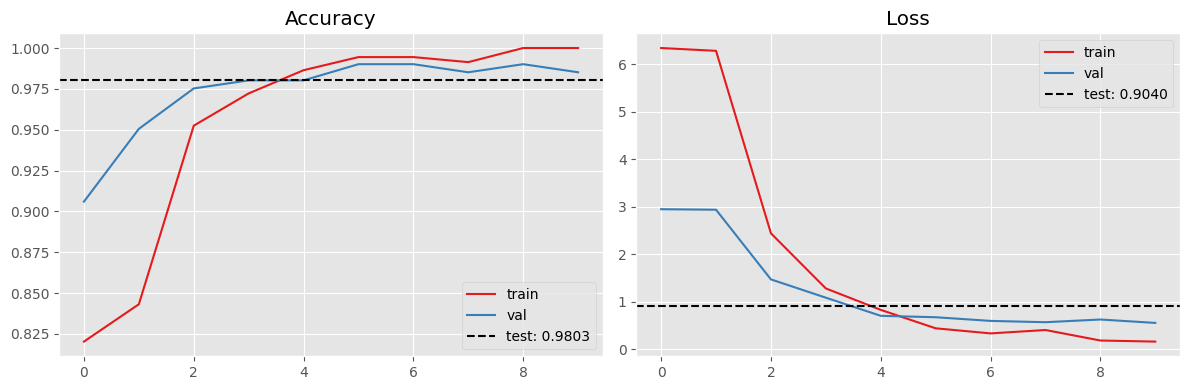

In [ ]:
train_accs = [x['train_acc'] for x in histories]
train_losses = [x['train_loss'] for x in histories]
val_accs = [x['val_acc'] for x in histories]
val_losses = [x['val_loss'] for x in histories]

plt.rcParams['axes.grid'] = True
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_accs, label='train', color=colors[0])
plt.plot(val_accs, label='val', color=colors[1])
plt.axhline(y=test_acc, color='black', linestyle='--', label=f'test: {test_acc:.4f}')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='train', color=colors[0])
plt.plot(val_losses, label='val', color=colors[1])
plt.axhline(y=test_loss, color='black', linestyle='--', label=f'test: {test_loss:.4f}')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()

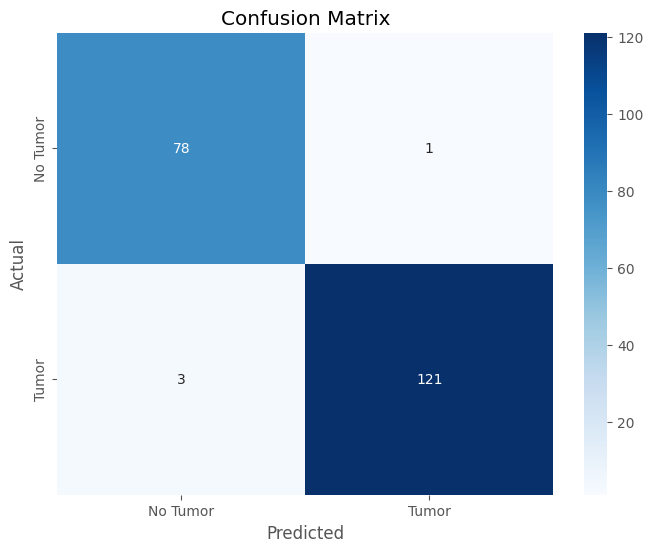

In [ ]:
cm = confusion_matrix(targets, predictions)

plt.rcParams['axes.grid'] = False
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Tumor', 'Tumor'], yticklabels=['No Tumor', 'Tumor'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(targets, predictions, target_names=['No Tumor', 'Tumor']))

              precision    recall  f1-score   support

    No Tumor       0.96      0.99      0.97        79
       Tumor       0.99      0.98      0.98       124

    accuracy                           0.98       203
   macro avg       0.98      0.98      0.98       203
weighted avg       0.98      0.98      0.98       203



In [ ]:
def plot_cam(model: models.resnet.ResNet, image_paths: list, targets: list) -> None:
    model = model.eval()

    target_layer = [model.layer4[-1]]
    cam = GradCAM(model=model, target_layers=target_layer)

    plt.rcParams['axes.grid'] = False
    fig, axs = plt.subplots(2, 4, figsize=(14, 7))

    for i, (image_path, target) in enumerate(zip(image_paths, targets)):
        image = Image.open(image_path).convert('RGB')
        image = transforms.ToTensor()(image)

        image_tensor = image.unsqueeze(0)

        image = image.numpy().transpose((1, 2, 0))
        image = np.clip(image, 0, 1)

        targets = [ClassifierOutputTarget(target)]
        grayscale_cam = cam(input_tensor=image_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0, :]

        visualization = show_cam_on_image(np.array(image_tensor[0].permute(1, 2, 0)), grayscale_cam, use_rgb=True)

        axs[1, i].imshow(image)
        axs[1, i].set_title('Original')

        axs[0, i].imshow(visualization)
        axs[0, i].set_title('Grad-CAM')

    plt.tight_layout()
    plt.show()

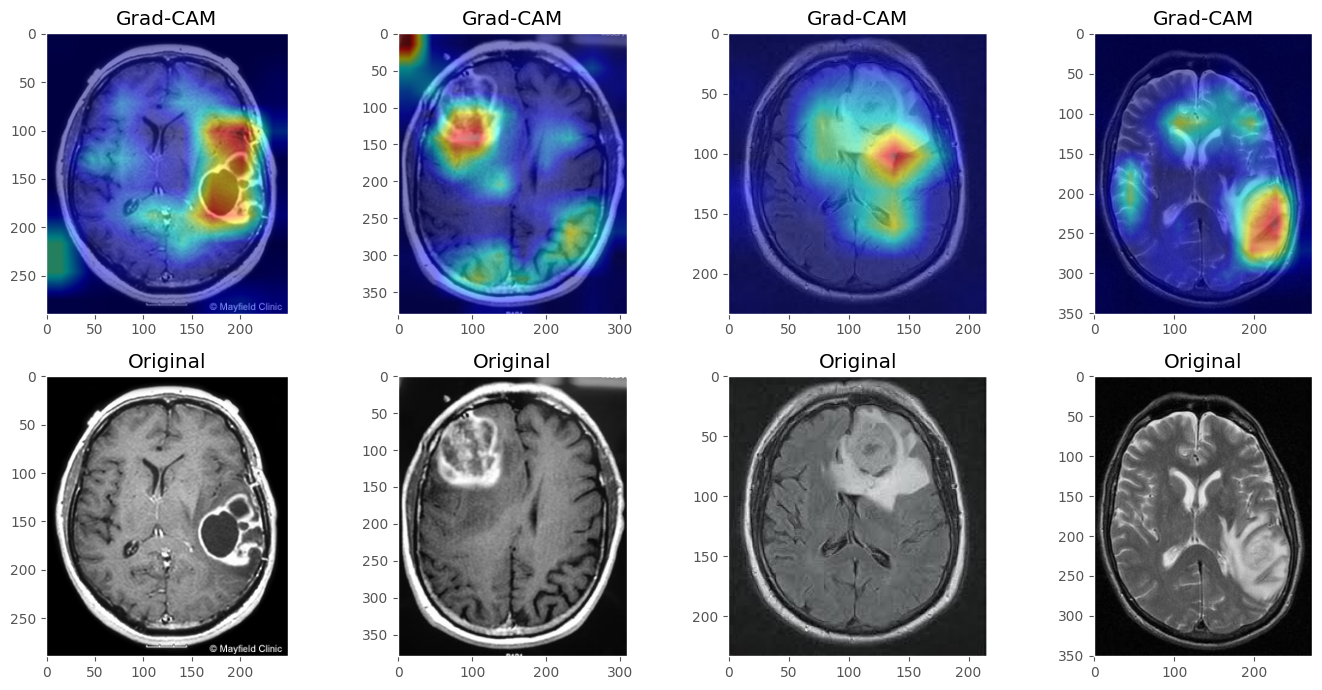

In [ ]:
image_paths = [os.path.join(tumors_path, filename) for filename in os.listdir(tumors_path)][24:28]
plot_cam(best_model, image_paths, [1] * 4)

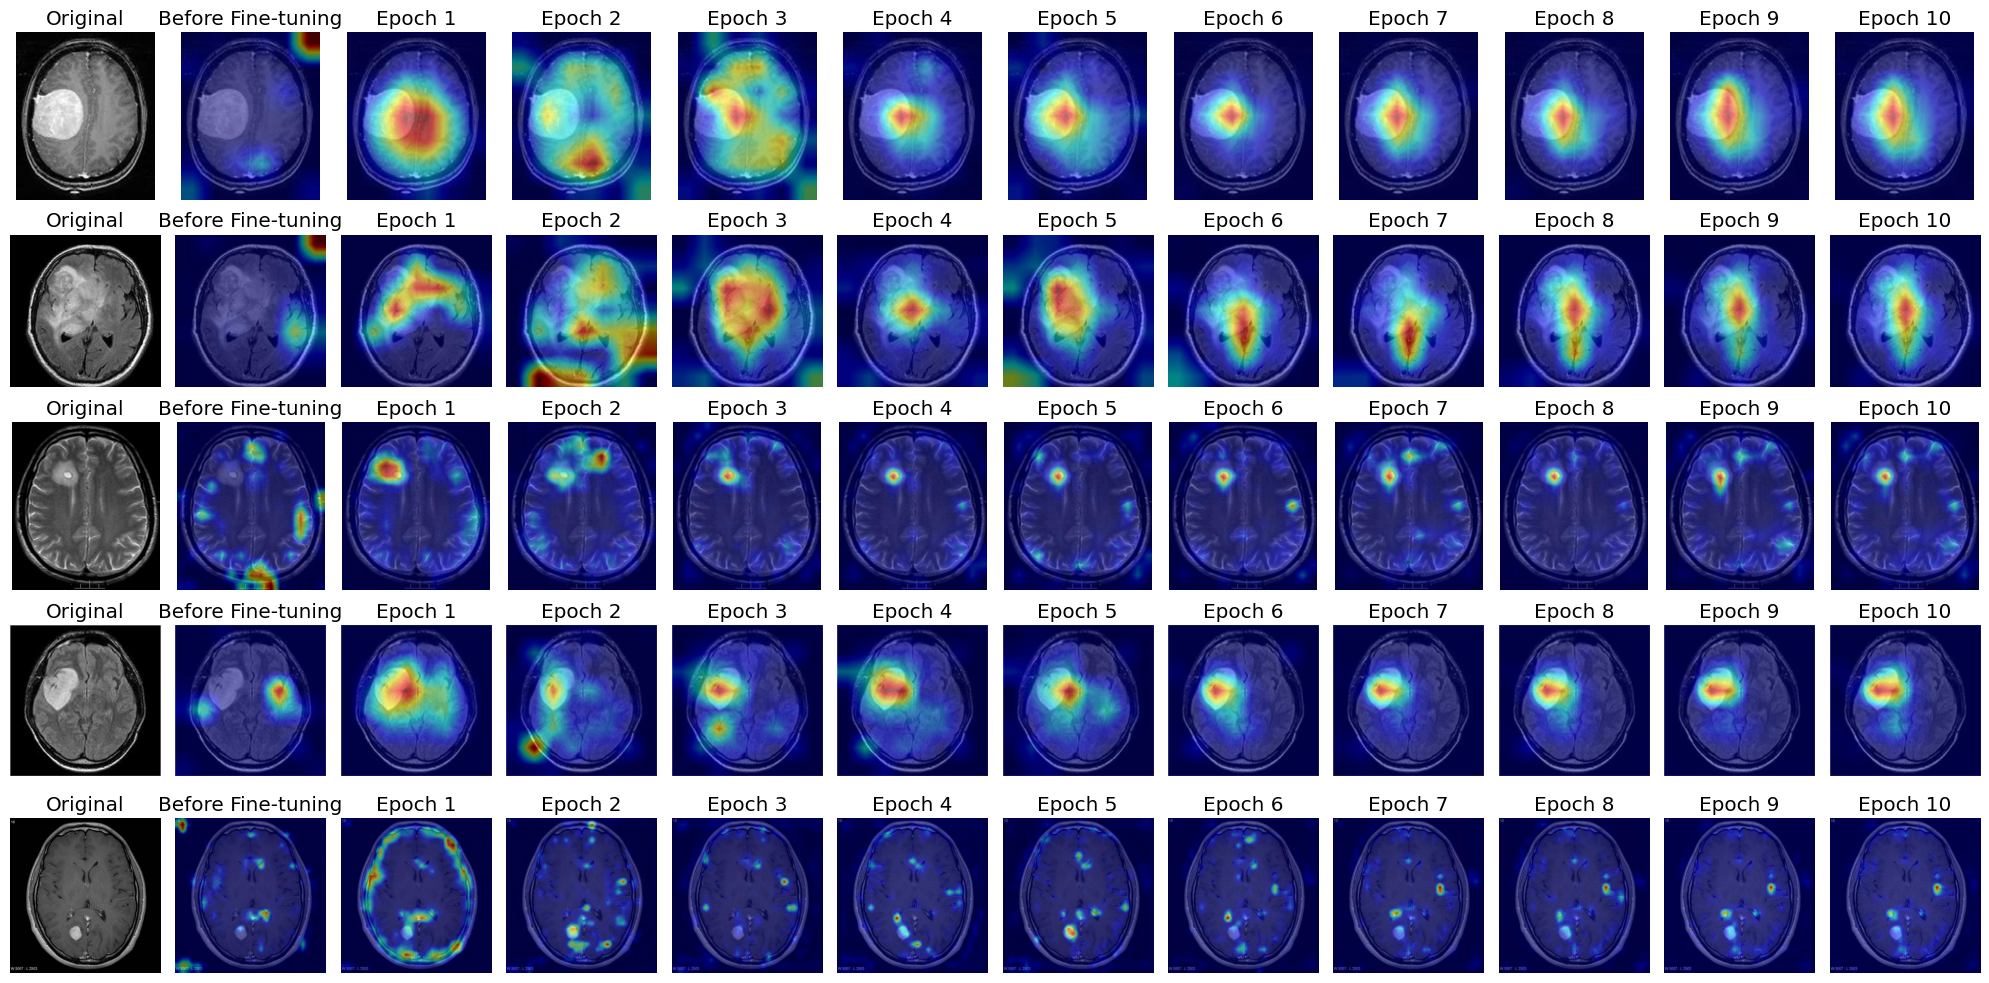

In [ ]:
samples = [
    '/kaggle/working/samples/Y1.jpg',
    '/kaggle/working/samples/Y2.jpg',
    '/kaggle/working/samples/Y3.jpg',
    '/kaggle/working/samples/Y4.jpg',
    '/kaggle/working/samples/Y6.jpg'
]

fig, axs = plt.subplots(len(samples), max_epochs + 2, figsize=(20, 10))
start_index = 0
for row in range(len(samples)):
    filename = Image.open(samples[start_index])
    axs[row, 0].imshow(filename, cmap='gray')
    axs[row, 0].set_title('Original')
    axs[row, 0].axis('off')
    start_index += 1

    original_filename = filename.filename.split("/")[-1].split(".")[0]

    for col in range(1, max_epochs + 2):
        filename = Image.open(f'samples/{original_filename}-cam-epoch-{col-1}.jpg')
        axs[row, col].imshow(filename, cmap='gray')
        if col == 0:
            title = "Original"
        if col == 1:
            title = "Before Fine-tuning"
        if col > 1:
            title = f'Epoch {col - 1}'
        axs[row, col].set_title(title)
        axs[row, col].axis('off')

plt.tight_layout()
plt.show()